# Some experiments on a 5 substations test case
Try me out interactively with: [![Binder](https://github.com/Grid2Op/grid2op/blob/master/getting_started/img/badge_logo.svg?raw=1)](https://mybinder.org/v2/gh/Grid2Op/grid2op/master)

To demonstrate the use of the grid2op framework, we show how to make some quick studies on a purely fictitious test case, a 5 bus system.

This system should not be used for in-depth research purposes. It is provided here as a simple example to get familiar with the use of the grid2op framework.

<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">
Execute the cell below by removing the # character if you use google colab !

Cell will look like:
```python
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)
```
<img src="https://colab.research.google.com/assets/colab-badge.svg" width="200">

In [33]:
!pip install grid2op[optional]  # for use with google colab (grid2Op is not installed by default)

First, we have to create an environment:

In [34]:
import grid2op
from tqdm.notebook import tqdm  # for easy progress bar
display_tqdm = False  # this is set to False for ease with the unitt test, feel free to set it to True
from grid2op.PlotGrid import PlotMatplot
env = grid2op.make("rte_case5_example", test=True)

/usr/local/lib/python3.11/dist-packages/grid2op/MakeEnv/Make.py:453: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


## Inspect the powergrid

In grid2op, to make the powergrid more concrete, we also added some visual capabilities to represent, for example, the names of the objects on the grid, or the thermal limit, or any other data you want. All of that is for now only available in the matplotlib "plot helper" and can be accessed as follows.

### Plotting the layout of the graph
This utility function allows you to view the location of the objects on the map. Each object has its own color, and is represented with its name and its id (id starts at 0, following Python convention).

In [35]:
plot_helper = PlotMatplot(env.observation_space)

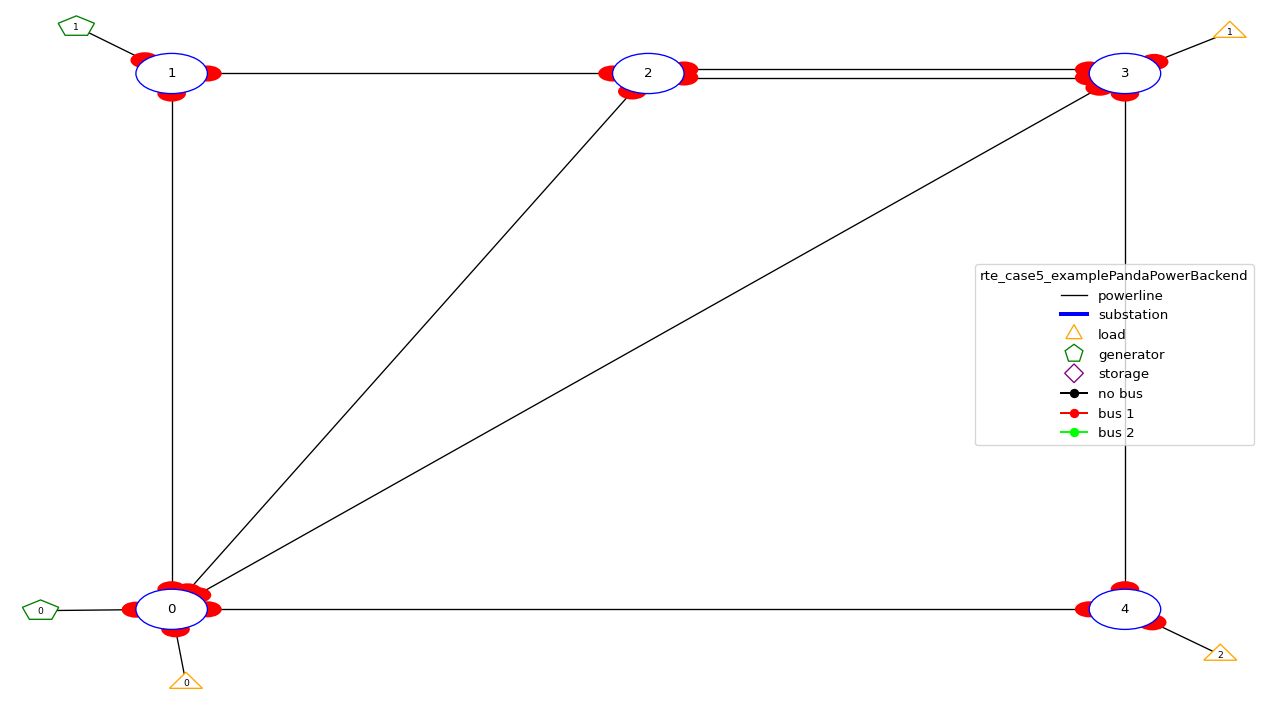

In [36]:
fig = plot_helper.plot_layout()

### Visualizing data on the grid

With the same method, it is also possible to visualize any data on the powergrid. For example, we can inspect the thermal limit (line property) as follow:

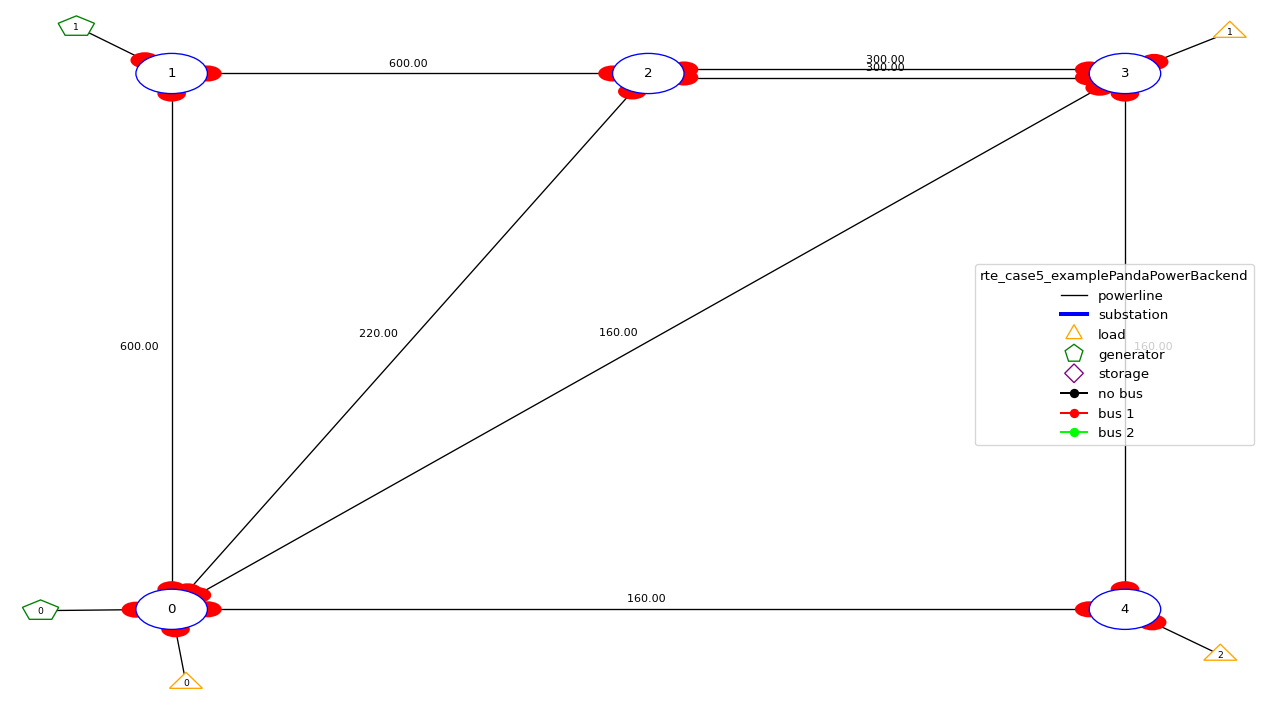

In [37]:
_ = plot_helper.plot_info(line_values=env._thermal_limit_a)

Similarly, it is possible to display some data about the generators, for example the maximum power they can produce.

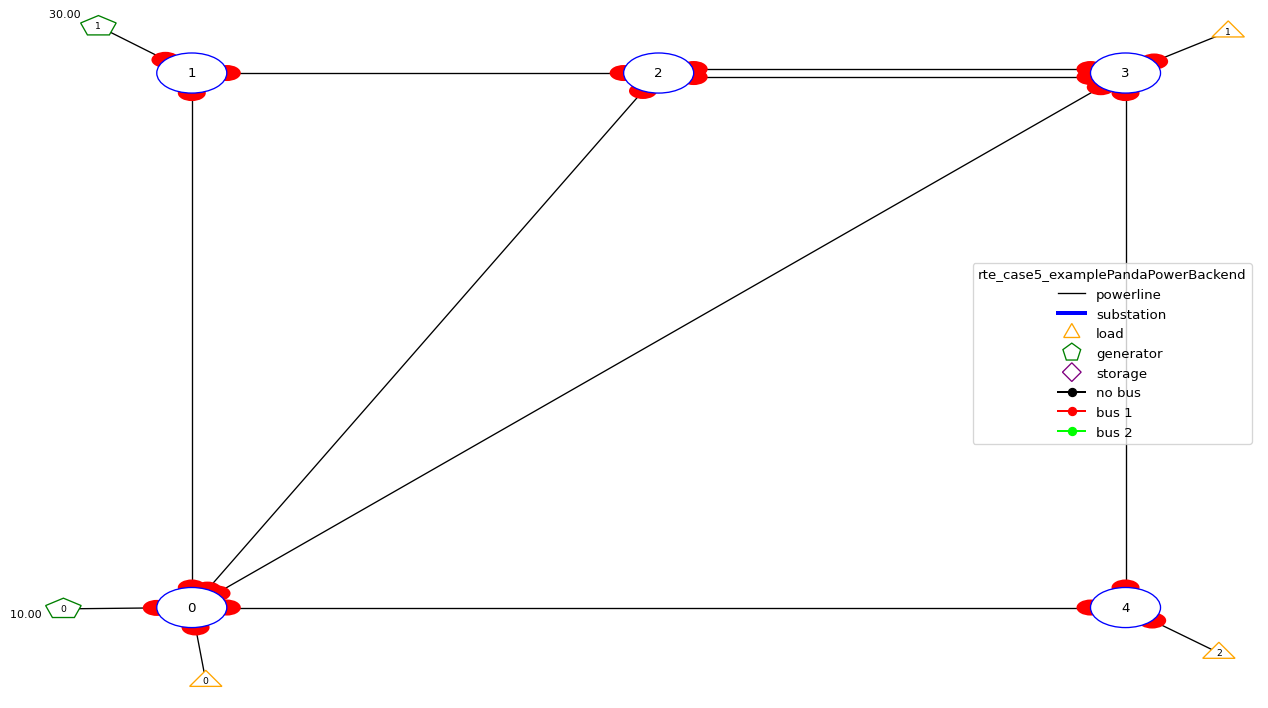

In [38]:
_ = plot_helper.plot_info(gen_values=env.gen_pmax)

Of course we can also project on the powergrid some information about the loads, for example their ID

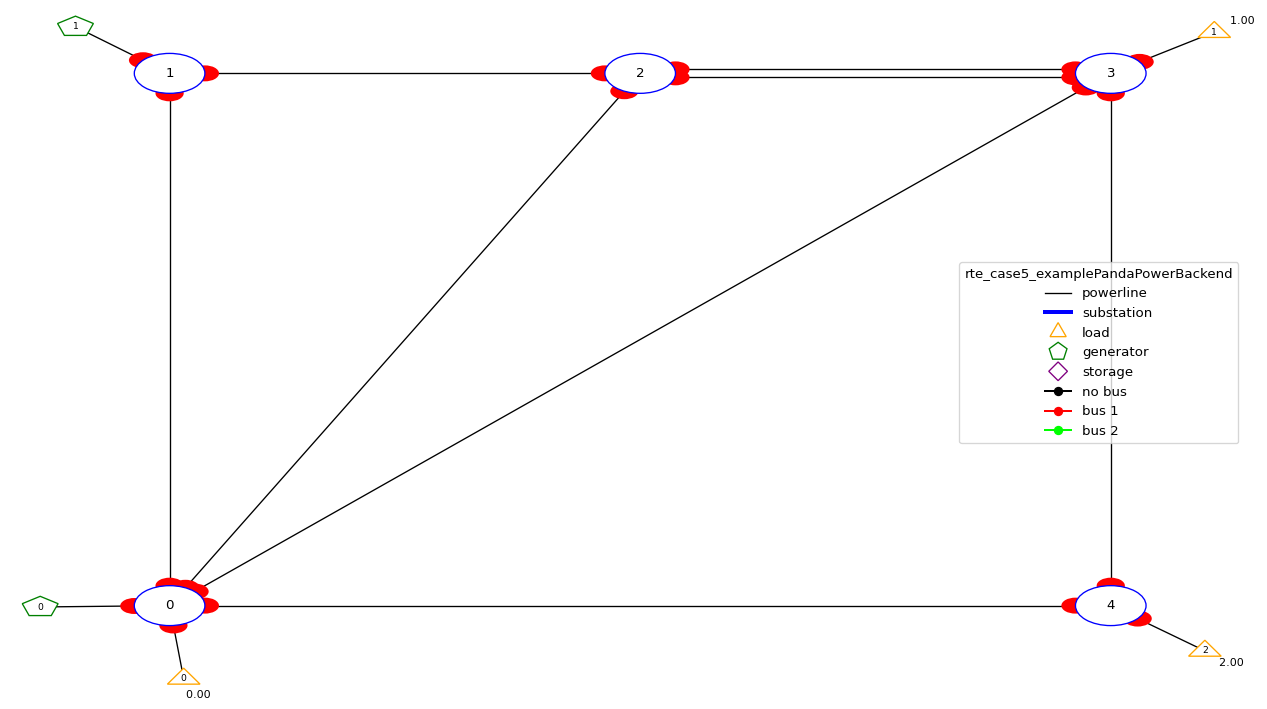

In [39]:
_ = plot_helper.plot_info(load_values=[el for el in range(env.n_load)])

## Create an agent

We can see how well the "do nothing" agent (the most basic imaginable) performs, using some "gym like" methods (see http://gym.openai.com/)

In [40]:
from grid2op.Agent import DoNothingAgent
my_agent = DoNothingAgent(env.action_space)

We run the "standard gym loop", and we save all the observations:

In [41]:
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
done = False
nb_step = 0
with tqdm(total=env.chronics_handler.max_timestep(), disable=not display_tqdm) as pbar:
    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

We can check if the episode has been completed, or if there has been a "game over":

In [42]:
print("Number of timesteps computed: {}".format(nb_step))
print("Total maximum number of timesteps possible: {}".format(env.chronics_handler.max_timestep()))

Number of timesteps computed: 94
Total maximum number of timesteps possible: 2016


As we see here, there is a "game over": The agent successfully managed to run the network 94 timesteps, while the episode could have lasted 2016.

Let's try to investigate this, for example by plotting the last observation.

First, we need to create a utility object to make the plot:

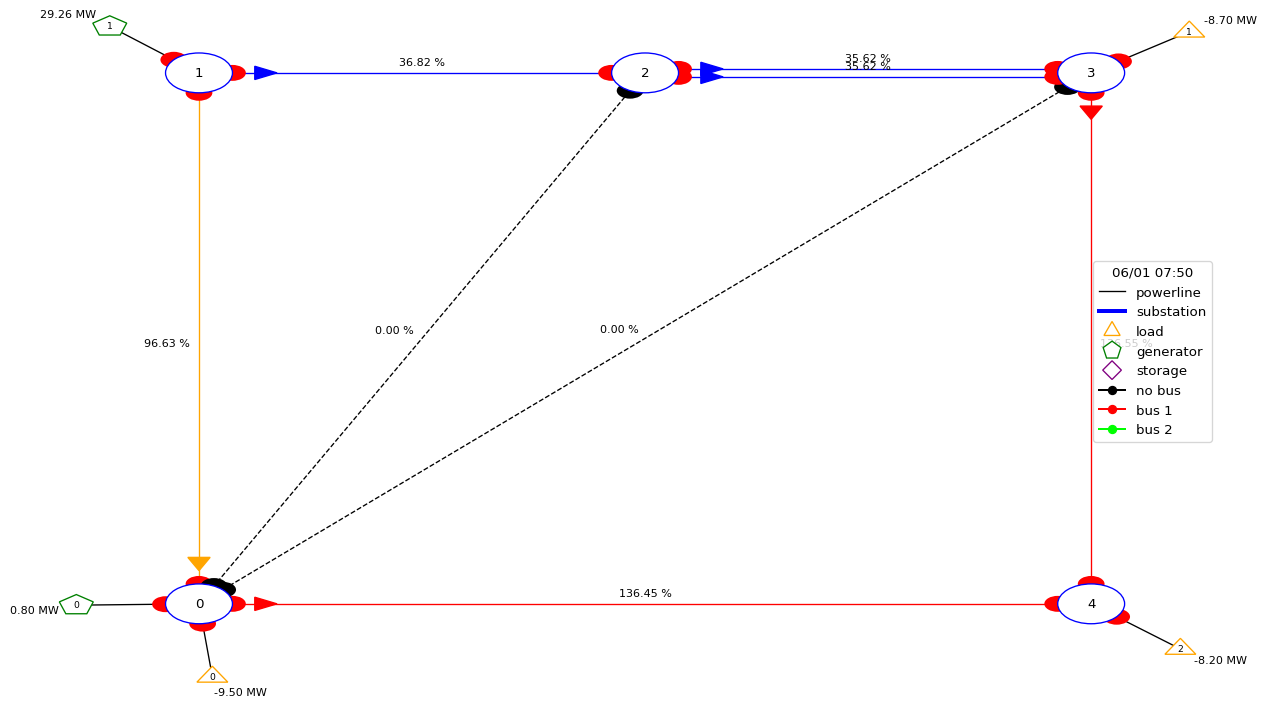

In [28]:
last_obs = all_obs[-1]
_ = plot_helper.plot_obs(last_obs)

As we can see, the last obsevation is pretty clear: 4 powerlines have been disconnected, thus isolating the load on the bottom right. This has led to a game over.

It's also possible, of course, to inspect the previous state, just before this one:

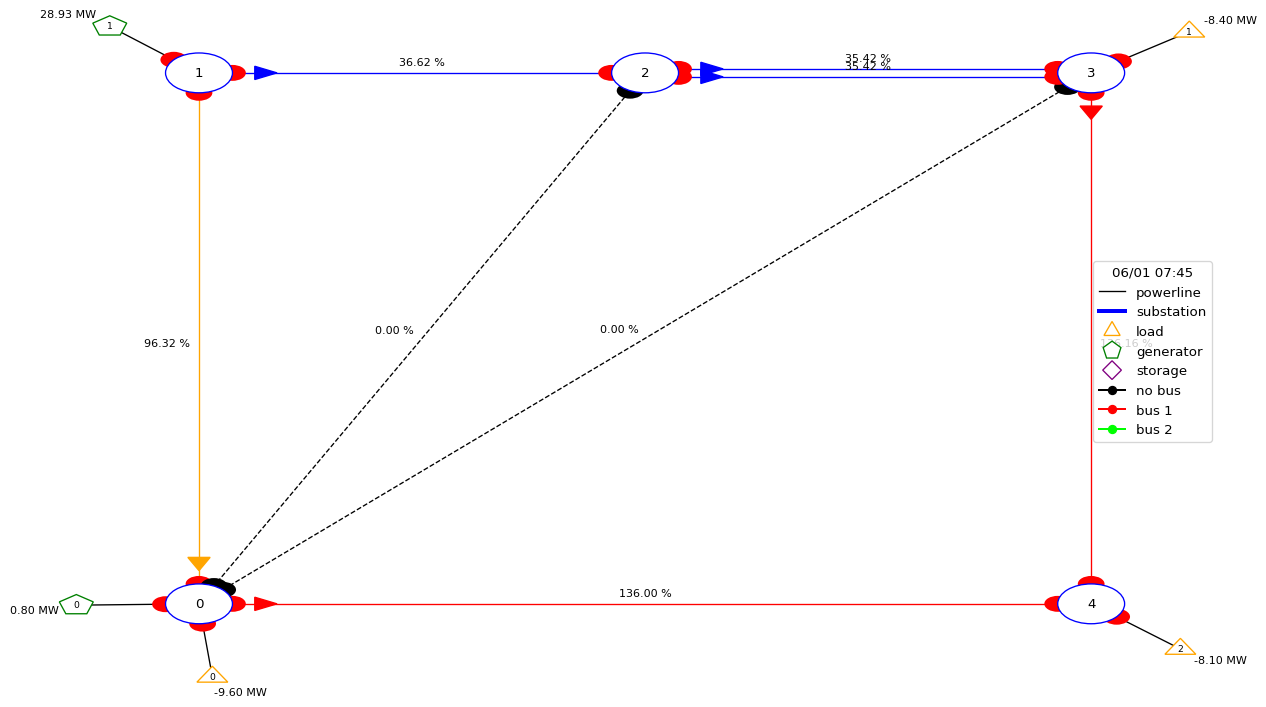

In [29]:
previous_obs = all_obs[-2]
_ = plot_helper.plot_obs(previous_obs)

And now we can see the cause of the problem: all the powerlines that could provide power on the bottom right load are overloaded in this situation, so the protection worked and disconnected the lines to prevent impacting the surroundings.

# Highly non linear and non local effects

The previous case was particularly suited to get started with the problem adressed by the grid2op platform. In this second section we will show what is the principal way of acting on a grid and illustrate why it is rather difficult to do so.

For that, we will use the "rte_case14_realistic" grid shown below

/usr/local/lib/python3.11/dist-packages/grid2op/MakeEnv/Make.py:453: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


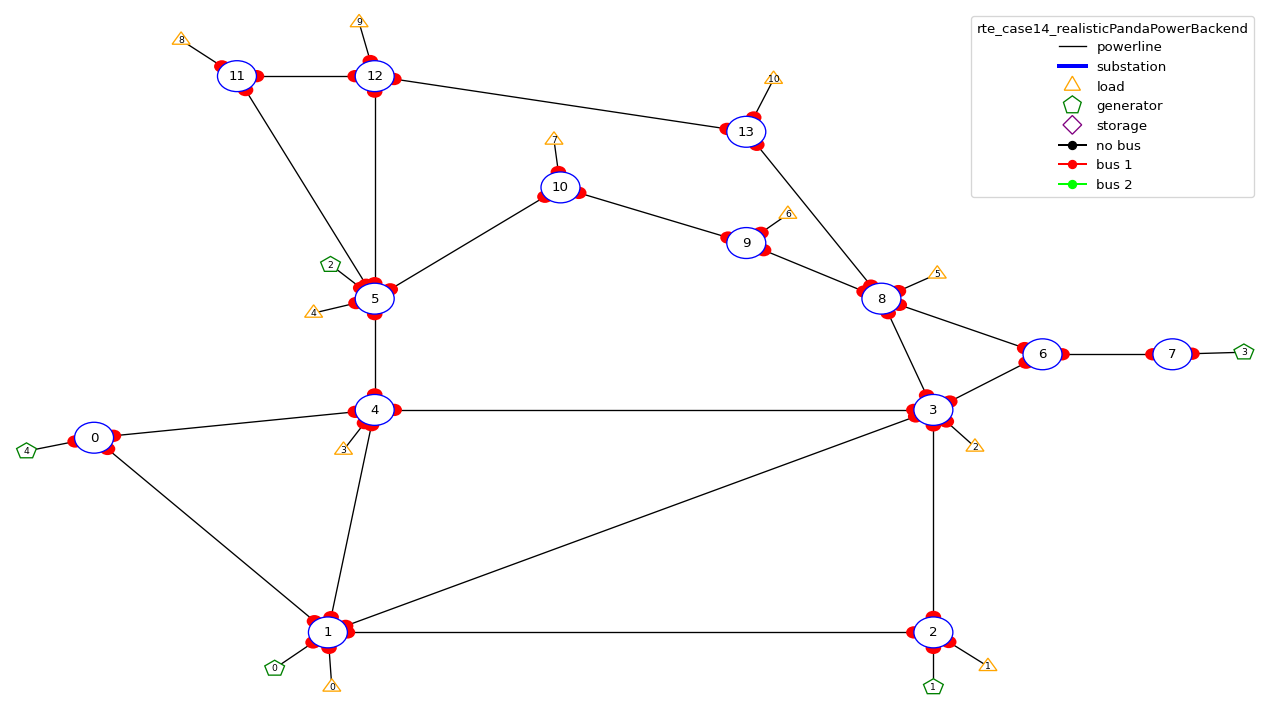

In [30]:
env_14 = grid2op.make("rte_case14_realistic", test=True)
plot_helper_14 = PlotMatplot(env_14.observation_space)
_ = plot_helper_14.plot_layout()

Now let's, like before, plot an observation

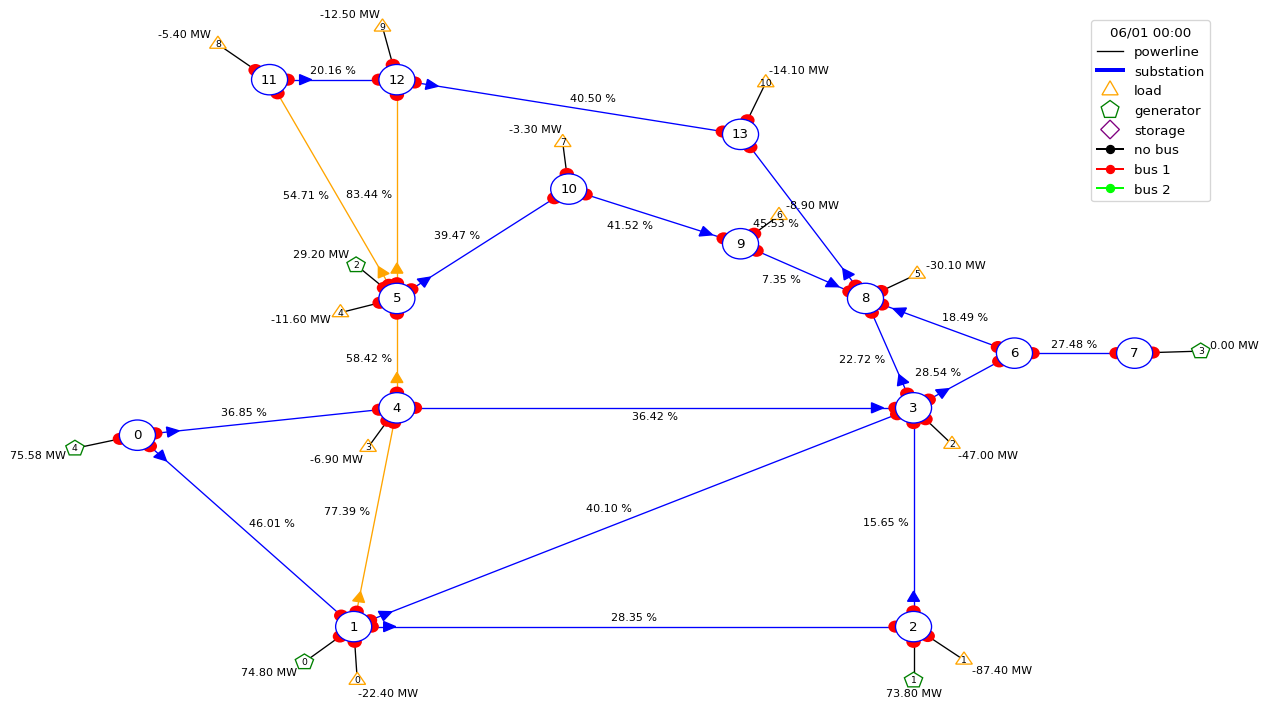

In [31]:
obs_before = env_14.reset()
_ = plot_helper_14.plot_obs(obs_before)

As stated in the previous notebooks, there are two main types of actions in grid2op: Actions that change the status of powerlines (connected/disconnected) and actions that change the topology in a given substation.

Note that connecting / disconnecting powerline can have a global, highly non linear impact on the powergrid as illustrated below, when we disconnect the powerline of id `17` going from substation `4` to substations `5`.

The way we interact with the environment is described in detail in notebook [03_Action](03_Action.ipynb), so we focus here only on the consequences of these actions.

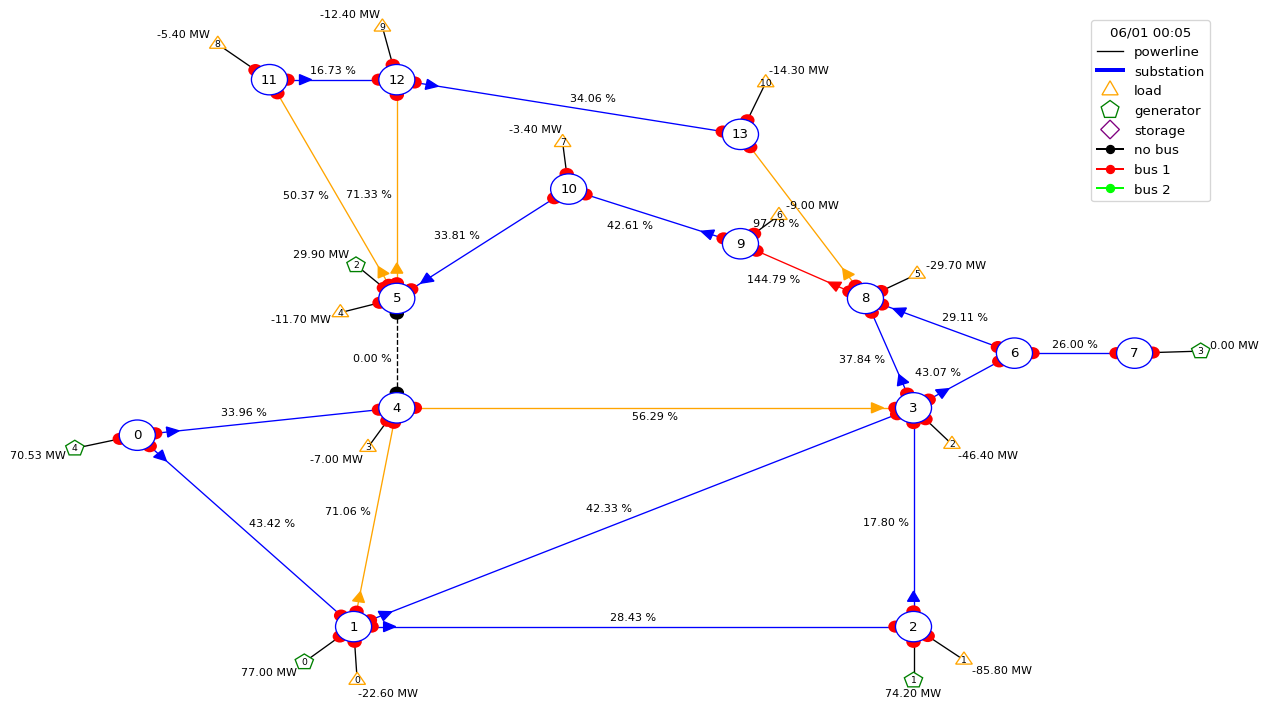

In [32]:
act = env_14.action_space.disconnect_powerline(line_name='4_5_17')
obs_after, reward, done, info = env_14.step(act)
_ = plot_helper_14.plot_obs(obs_after)

We can have a "quick" look on the effect of this action.

First let's look at the bottom right part of the grid. We can see that flow there did not change too much:

|origin | extremity | flow before | flow after |
|-------|-----------|-------------|------------|
| 0 | 1 | 46.01% |43.42%|
| 0 | 4 | 36.85% |33.96%|
| 1 | 4 | 77.39% |71.06%|
| 1 | 2 | 28.35% |28.43%|
| 1 | 3 | 40.10% |42.33%|
| 2 | 3 | 15.65% |17.80%|
| 4 | 3 | 36.42% |56.29%|

Though some of these powerlines are really close (in terms of graph distance \*) they do not seem to be impacted too much (see the powerline going from (substation) 0 to 4 and the one going from 1 to 4).

On the other hand, if you look at the topmost part of the grid, you can spot really high differences, though these powerlines are extremely far (in terms of graph distance) from the powerline disconnected (3 or 4 substations apart for some of them).

|origin | extremity | flow before | flow after |
|-------|-----------|-------------|------------|
| 3 | 8 | 22.72% |37.84% |
| 8 | 9 | 7.35% |144.79% (opposite direction)|
| 9 | 10 | 41.52% |42.61% (opposite direction)|
| 8 | 13 | 45.53% |97.78%|

To recap, some powerline next to the disconnected one have approximately the same flows (36.85% to 33.96% for example) while some others "really far away" are dramatically impacted by this change, seeing their flow completely blowing up from roughly $7\%$ to more than $140 \%$.


\* When we mention "distance" on a graph it is more of a figure of speech rather than a well defined mathematical distance on a set (with its triangle inequality, etc). We can intuitively define the "graph distance" between two powerlines by the smallest number of lines we need to "go through" if we want to move from the the first powerline to the second.

Of course, the same kind of effect can be observed after a change in the topology of some substations. We will not illustrate this however.